# Investigating the functions


In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
%matplotlib inline

f1_inp = np.load("./../function_6/initial_inputs.npy")
f1_out = np.load("./../function_6/initial_outputs.npy")
f1_out



file2_inp = np.load("./../../initial_data2/function_6/initial_inputs.npy")
file2_out = np.load("./../../initial_data2/function_6/initial_outputs.npy")

f1_inp = np.concatenate((f1_inp, file2_inp))
f1_out = np.concatenate((f1_out, file2_out))

q1_inp = [0.465991, 0.297246, 0.506673, 0.798397, 0.058303]
q1_out = [-0.35877194997056516]

q2_inp = [3.8510e-03, 8.1210e-03, 2.1452e-02, 7.7182e-02, 1.0000e-06]
q2_out = [-2.143295938267809]


q3_inp = [0.318386, 0.32892 , 0.545503, 0.907816, 0.037242]
q3_out = [-0.40800951491298837]

q4_inp = [0.391766, 0.367967, 0.501224, 0.766221, 0.157925]
q4_out = [-0.25145968163723864]


q5_inp = [0.333517, 0.44857 , 0.401418, 0.737025, 0.088651]
q5_out = [-0.3841208933110867]

f1_inp = np.vstack((f1_inp, q1_inp, q2_inp,q3_inp,q4_inp, q5_inp))
f1_out = np.append(f1_out, [q1_out, q2_out,q3_out,q4_out,q5_out])
    
f1_inp, f1_out

max(f1_out)

-0.25145968163723864

In [2]:
max(f1_out)

-0.25145968163723864

[False False False False False False False False False False False False
 False False False False False False False False False False False False]


# Exploratory Data Analysis (EDA) for Bayesian Optimization 

## **Objective**
The goal of the Exploratory Data Analysis (EDA) is to investigate the characteristics of the input-output relationships, data quality, and patterns that influence the performance of Bayesian Optimization. This analysis will help guide the selection of kernel parameters, acquisition functions, and input transformations to optimize model performance and robustness.
- Prior Knowledge: One of the features might not impact the outcome, consider to remove it


1. **Data Quality**  
   - Identify outliers via z-scores or IQR (ensures kernel parameters aren’t distorted by extreme values, example an outlier can create unrealistic length scales or amplitude of kernel parameters). Consider removing or transforming them.
   - Check for missing/null values and decide on imputation or removal (helps avoid skewing the GP’s fit). Remove duplicates if there is any  (prevents overemphasis on certain points).  


2. **Data Distribution**  
   - Plot histograms to spot skewness (so we can apply tansfromation of input and output), to address heteroscedascity.  
   - Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000), larger ranges dominate distance calculations, distorting kernel behavior).
    - Check, variance, skewnes which can be needed in further steps

3. **Input-Output Relationships**  
   - Use correlation matrices to find strong or weak drivers of the target (remove features that are not relevant and add noise to the data).  
   - Visualize scatter/surface plots (reveals potential nonlinearity or interactions for better GP modeling).
   

6. **Noise and Uncertainty**  
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).  
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - Consider removing  as the step above if it removes the noise 
     - If skewness is low but variance is high in RESIDUALS, focus on adding a noise term to the kernel, reults from step 2
7. **Feature Engineering**  
   - Apply dimensionality reduction (e.g., PCA) if many correlated features (simplifies model, reduces noise).  
   - Assess feature importance (e.g., SHAP) to prioritize critical inputs (focuses GP where it matters).
   

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput
   - Lengthscle check variance on input
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
   - Select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Match kernel amplitude to output variance (captures overall scale of the data).  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 

8. **Acquisition Function Behavior**  
   - Monitor exploration-exploitation trade-offs (e.g., EI, PI, UCB) to ensure effective sampling (speeds convergence).  
   - Adjust parameters like \(\beta\) or \(\xi\) to fine-tune that balance (enhances optimization efficiency).


9. **Iterative Refinement**  
   - Revisit EDA after initial Bayesian runs (refine kernel hyperparameters, acquisition settings).  
   - Visualize updated surfaces and residuals (validates improvements and ensures robust GP performance).


In [3]:
from scipy.stats import skew 

pd_inp = pd.DataFrame(f1_inp)
pd_out = pd.DataFrame(f1_out, columns=["Output"])


pd_inp.describe()
pd_out.describe()

pd_inp.isnull().sum()  # No null on input 0 , 1 are the columns 
pd_out.isnull().sum()  # No null on output
sum(pd_inp.duplicated())   # 0 duplicates
sum(pd_out.duplicated())   # 0 duplicates

0

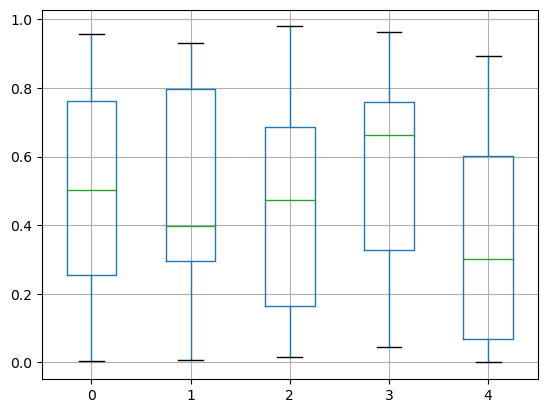

In [6]:
## Checking for outliers

pd_inp.boxplot() # OUTLIER DEDECTED ON THE 3RD FEATURE OF INPUTS
plt.show()

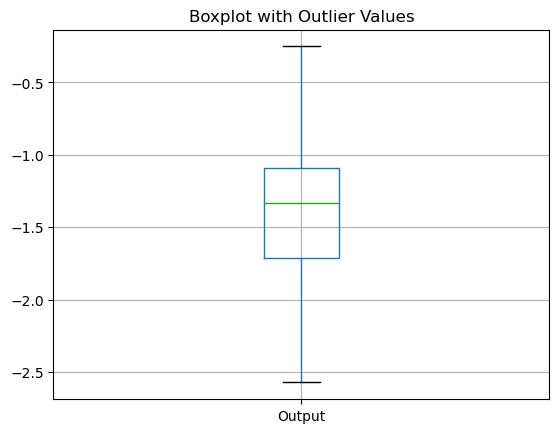

In [7]:
import matplotlib.pyplot as plt

# Create the boxplot
ax = pd_out.boxplot()

# Identify outliers using the 1.5*IQR rule
iqr = pd_out.quantile(0.75) - pd_out.quantile(0.25)
lower_bound = pd_out.quantile(0.25) - 1.5 * iqr
upper_bound = pd_out.quantile(0.75) + 1.5 * iqr

# Detect outliers
if isinstance(pd_out, pd.Series):
    outliers = pd_out[(pd_out < lower_bound) | (pd_out > upper_bound)]
elif isinstance(pd_out, pd.DataFrame):
    # Select the first column for comparison if it's a DataFrame
    column_name = pd_out.columns[0]
    outliers = pd_out.loc[(pd_out[column_name] < lower_bound[column_name]) |
                          (pd_out[column_name] > upper_bound[column_name]), column_name]

# Annotate each outlier
if isinstance(outliers, pd.Series):
    for outlier_idx, outlier_value in outliers.items():
        ax.annotate(f"{outlier_value:.2f}", xy=(1, outlier_value), xytext=(1.05, outlier_value),
                    arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=10)

# Show the plot
plt.title("Boxplot with Outlier Values")
plt.show()


## Distribution 

In [8]:
# Find the outlier (minimum value, assuming outlier is the smallest value)
outlier_idx = np.argmin(f1_out)
outlier = f1_out[outlier_idx]

# Exclude the outlier and find the second closest value to the outlier
remaining_points = np.delete(f1_out, outlier_idx)  # Remove the outlier
second_furthest_point = remaining_points[np.argmin(np.abs(remaining_points - outlier))]

# Calculate the distance between the outlier and the second closest point
distance = outlier - second_furthest_point

# Update the outlier value
new_point = second_furthest_point + distance / 2.2  # Halve the distance
f1_out[outlier_idx] = new_point  # Update the array

# Output relevant values
outlier, second_furthest_point, distance, new_point, f1_out


(-2.5711696316081234,
 -2.1557677641786004,
 -0.415401867429523,
 -2.3445867948283836,
 array([-0.71426495, -1.20995524, -1.67219994, -1.53605771, -0.82923655,
        -1.24704893, -1.23378638, -1.69434344, -2.34458679, -1.30911635,
        -1.14478485, -1.91267714, -1.62283895, -1.35668211, -2.0184254 ,
        -1.70255784, -1.29424696, -0.93575656, -2.15576776, -1.74688209,
        -0.35877195, -2.14329594, -0.40800951, -0.25145968]))

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
        [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

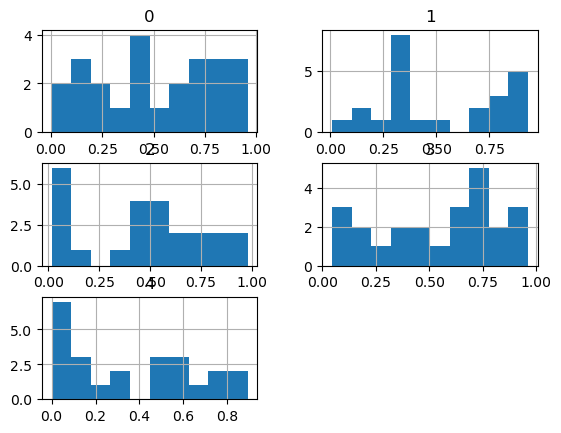

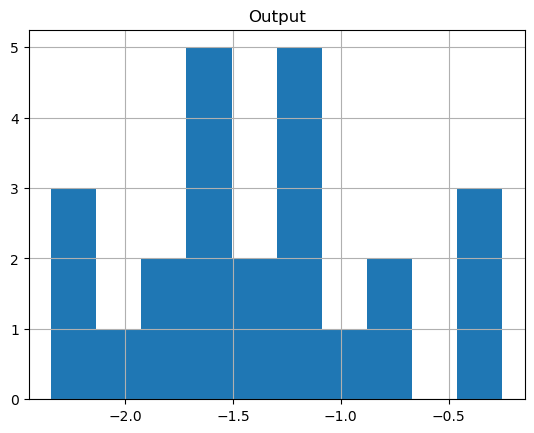

In [9]:
pd_inp.hist(), pd_out.hist()

In [10]:
skew(f1_inp),skew(f1_out)


np.var(f1_inp),np.var(f1_out)

(0.08908258536230021, 0.3187727261950125)

In [11]:
# Distribution affected by outlier 

# Input/Output Relationship Analysis 

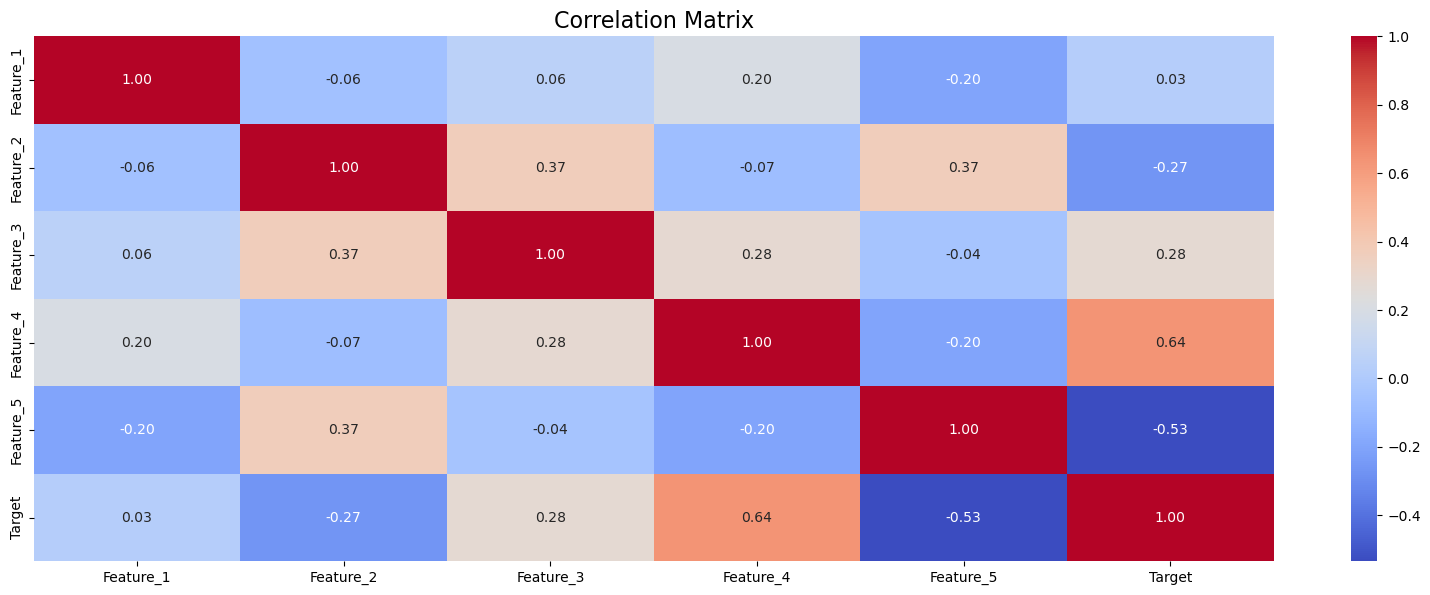

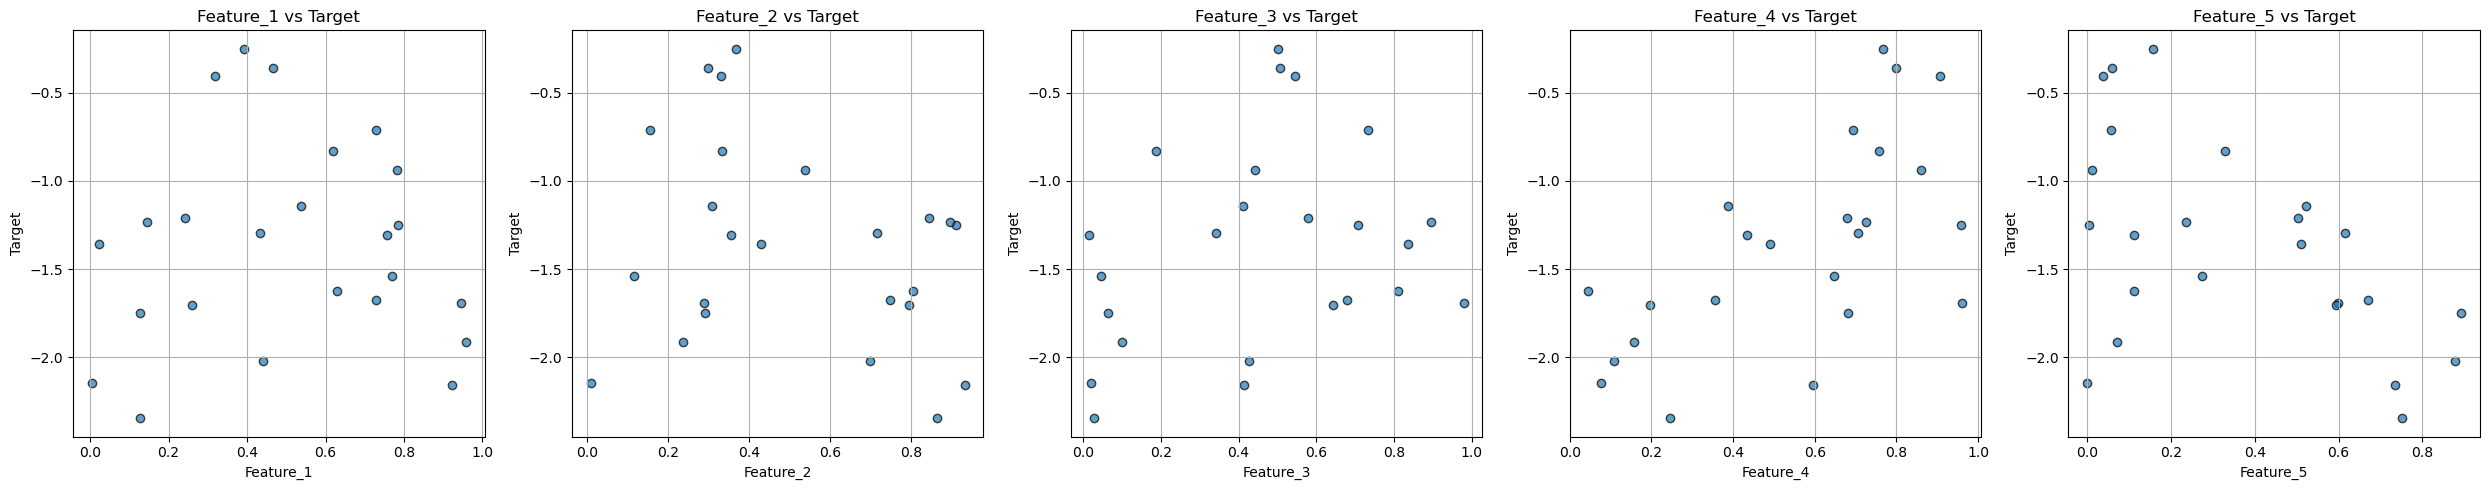

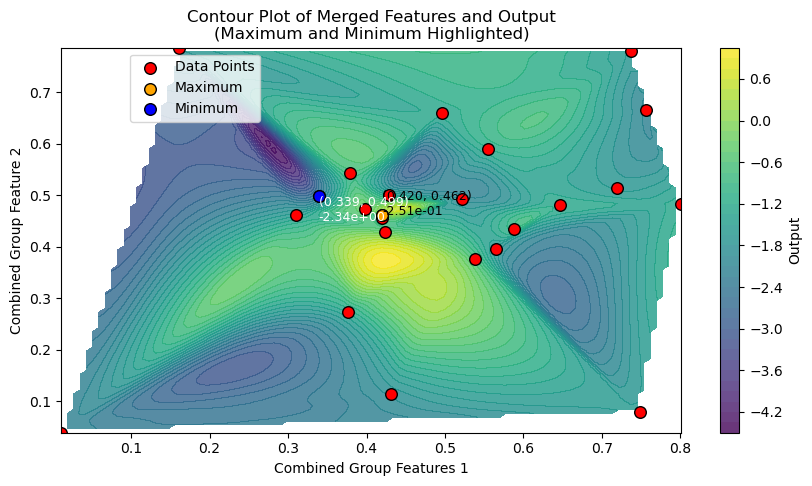

Max: -2.51e-01 at (0.4203, 0.4621)
Min: -2.34e+00 at (0.3390, 0.4989)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Ensure f1_out is 1D
f1_out = f1_out.ravel()
num_features = f1_inp.shape[1]

#############################
# Layout with GridSpec for Correlation Matrix and Scatter Plots
#############################
import matplotlib.gridspec as gridspec

# Create a figure with GridSpec: top for correlation matrix, bottom for scatter plots
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])  # Two rows: correlation matrix and scatter plots

# --- Top: Correlation Matrix ---
ax_corr = fig.add_subplot(gs[0])
data = np.hstack((f1_inp, f1_out.reshape(-1, 1)))
correlation_matrix = np.corrcoef(data.T)

sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f",
    xticklabels=[f"Feature_{i+1}" for i in range(num_features)] + ["Target"],
    yticklabels=[f"Feature_{i+1}" for i in range(num_features)] + ["Target"],
    ax=ax_corr
)
ax_corr.set_title("Correlation Matrix", fontsize=16)

# --- Bottom: Scatter Plots ---
fig_scatter, axes_scatter = plt.subplots(1, num_features, figsize=(5*num_features, 5))
for i in range(num_features):
    axes_scatter[i].scatter(f1_inp[:, i], f1_out, alpha=0.7, edgecolor="k")
    axes_scatter[i].set_xlabel(f"Feature_{i+1}")
    axes_scatter[i].set_ylabel("Target")
    axes_scatter[i].set_title(f"Feature_{i+1} vs Target")
    axes_scatter[i].grid(True)

plt.tight_layout()
plt.show()

#############################
# 3D Surface Plots for Two Feature Pairs
#############################

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import skew

# Example input data (replace with actual f1_inp and f1_out)
# f1_inp: shape (n_samples, n_features)
# f1_out: shape (n_samples,)
# Ensure f1_out is 1D
f1_out = f1_out.ravel()

def merge_features(data):
    """
    Merge features into two groups by averaging.
    Splits the columns into two halves and computes the mean of each half for each sample.
    """
    n_samples, n_features = data.shape
    # Determine splitting index (round up if odd number of features)
    split_idx = (n_features + 1) // 2  
    # First group: average of first half, second group: average of remaining
    group1 = np.mean(data[:, :split_idx], axis=1)
    group2 = np.mean(data[:, split_idx:], axis=1) if split_idx < n_features else np.zeros(n_samples)
    return group1, group2

# Merge features into two combined dimensions
x, y = merge_features(f1_inp)
z = f1_out

# Create grid points for interpolation over the range of merged features
grid_x, grid_y = np.mgrid[
    x.min():x.max():100j, 
    y.min():y.max():100j
]

# Interpolate the Z values for the grid using cubic method
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Identify max/min points on original data in merged space
max_idx, min_idx = np.argmax(z), np.argmin(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

# Plotting the contour plot
plt.figure(figsize=(10, 5))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
plt.scatter(x, y, color='red', edgecolor='black', s=70, label="Data Points")
plt.scatter([max_x], [max_y], color='orange', edgecolor='black', s=70, label="Maximum")
plt.text(max_x, max_y, f"({max_x:.3f}, {max_y:.3f})\n{max_z:.2e}", fontsize=9, color='black')
plt.scatter([min_x], [min_y], color='blue', edgecolor='black', s=70, label="Minimum")
plt.text(min_x, min_y, f"({min_x:.3f}, {min_y:.3f})\n{min_z:.2e}", fontsize=9, color='white',
         ha='left', va='top')
plt.xlabel("Combined Group Features 1")
plt.ylabel("Combined Group Feature 2")
plt.title("Contour Plot of Merged Features and Output\n(Maximum and Minimum Highlighted)")
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))
plt.show()

print(f"Max: {max_z:.2e} at ({max_x:.4f}, {max_y:.4f})")
print(f"Min: {min_z:.2e} at ({min_x:.4f}, {min_y:.4f})")


# def plot_3d_surface(feature_idx1, feature_idx2, title):
#     # Extract two features and target
#     x = f1_inp[:, feature_idx1]
#     y = f1_inp[:, feature_idx2]
#     z = f1_out

#     # Create grid points for interpolation
#     grid_x, grid_y = np.meshgrid(
#         np.linspace(x.min(), x.max(), 100),
#         np.linspace(y.min(), y.max(), 100)
#     )

#     # Interpolate the Z values for the grid
#     grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

#     # Plotting the surface
#     fig = plt.figure(figsize=(10, 6))
#     ax = fig.add_subplot(111, projection="3d")
#      # Surface plot
#     surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap="viridis", edgecolor="none", alpha=1)

#     # Adding red dots (ensure they are plotted after the surface)
#     ax.scatter(x_dots, y_dots, z_dots, color='red', s=50, label='Red Dots')

#     # Add color bar
#     cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
#     cb.set_label("Target")

#     # Label axes and title
#     ax.set_xlabel(f"Feature {feature_idx1+1}")
#     ax.set_ylabel(f"Feature {feature_idx2+1}")
#     ax.set_zlabel("Target")
#     plt.title(title)
#     plt.legend(loc="best")
#     plt.show()




### Conclusion about input/ouput relationship
- Feature 4 has got strongest corerlation
- After merging features we now know the area expected for imporvmnet

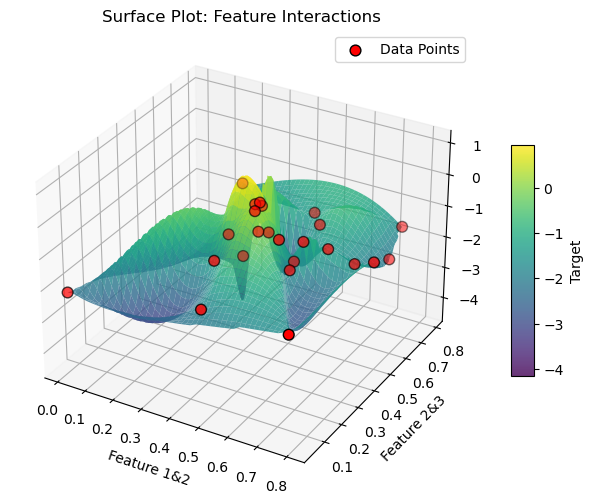

In [13]:
# x, y = DECLARED ABOVE
# z = f1_out

# Create grid points for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the Z values for the grid
grid_z = griddata(
    (x, y), z, 
    (grid_x, grid_y), 
    method="cubic"
)

  # This visual can be good for function 1 to identify the two local minimas   
#     # Handle potential issues with NaN values in grid_z
#     if np.isnan(grid_z).any():
#         grid_z = np.nan_to_num(grid_z)  # Replace NaNs with zeros or interpolated values

# Plotting the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    grid_x, grid_y, grid_z, 
    cmap="viridis", 
    edgecolor="none", 
    alpha=0.8
)
# Scatter points (data points)
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
ax.legend(loc="best")  # Add legend for clarity

cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Target")
ax.set_xlabel("Feature 1&2")
ax.set_ylabel("Feature 2&3")
#     ax.set_zlabel("Target")
plt.title("Surface Plot: Feature Interactions")
plt.show()
# else:
#     print("Surface plot requires exactly 2 features in the input data.")
    
    
# The red on the 3d surface plot its just to make the plot easier to see


# Analysing Noise and Uncertianty

Noise and Uncertainty
     
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2 
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2
- Test after you have built the surrogate model, if there are future that just add noise and affect predictions 

In [14]:
# Analysing skewnes and variance 




# Bench mark model for analysis( Linear Regression)

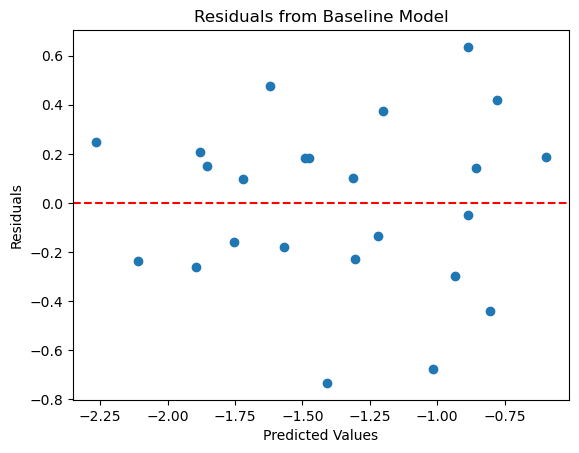

Residual Variance: 0.120
Residual Mean: 0.000


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example Data (replace with your data)
x = f1_inp
z = f1_out  # Observed target

# Fit a baseline model (Linear Regression)
model = LinearRegression()
model.fit(x, z)
z_pred = model.predict(x)  # Predictions from the baseline model

# Residuals
residuals = z - z_pred

# Plot Residuals
plt.scatter(z_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals from Baseline Model")
plt.show()

# Print Residual Statistics
print(f"Residual Variance: {np.var(residuals, ddof=1):.3f}")
print(f"Residual Mean: {np.mean(residuals):.3f}")


In [16]:
# Signal Variance (Variance of Predictions)
signal_variance = np.var(z_pred, ddof=1)

# Residual Variance (Variance of Noise)
residual_variance = np.var(residuals, ddof=1)
residual_skewness = skew(residuals)
# Signal-to-Noise Ratio (SNR)
snr = signal_variance / residual_variance

# Display Metrics
print(f"Signal Variance: {signal_variance:.3f}")
print(f"Residual Variance (Noise): {residual_variance:.3f}")
print(f"Residual Skewnes : {residual_skewness:.3f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.3f}")


Signal Variance: 0.213
Residual Variance (Noise): 0.120
Residual Skewnes : -0.357
Signal-to-Noise Ratio (SNR): 1.775


- A high  signal variance means that the model is understanding well patterns of data
- A low residual variance is desirable, as it indicates that predictions are close to the observed values. If the surrogate model reduces residual variance, it is an improvement over the benchmark.
- Residual Skewness: Shows the symmetry of prediction errors (residuals). For benchmarking: A skewness near zero indicates balanced prediction errors, aligning with the assumption of normally distributed residuals.
- Signal-to-Noise Ratio (SNR): The ratio of signal variance to noise variance, measuring how dominant the signal is over noise. For benchmarking: A higher SNR means the model is better at distinguishing the signal from noise.

# Conclusion:
- There is a high v Residual Variance (Noise): 21446.895

# Kernel Parameters Analysis

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput will match kernel amplitude to output variance (captures overall scale of the data). 
   - Lengthscle check variance on input, will select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 


In [17]:
output_variance = np.var(f1_out, ddof=1)
amplitude_init = np.sqrt(output_variance)
input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension


amplitude_init, length_scale_init, [extended_min_bounds, extended_max_bounds]

(0.576742932286666,
 array([0.30082685, 0.28995548, 0.30164144, 0.29171043, 0.30394399]),
 [array([-0.09153787, -0.08425402, -0.07970539, -0.04599105, -0.08928082]),
  array([1.05312854, 1.02424624, 1.07503405, 1.05325983, 0.98210101])])

- Start with the above Amplitude but let the optimizer refine it during training

- Start with the above Lenfthscale but let the optimizer refine it during training

- Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds

# ***************************** Output Transformation ******************************* 
- I will use Yeo-Johnson method to hanlde the heteroscedastic nature of the data, tranform outputs, and fic asymmetric skewness. 
- Reason I am using Yeo-Johnson is because we have positive and negative values as ouput 



(array([[<Axes: title={'center': 'Output'}>]], dtype=object),
 array([[<Axes: title={'center': '0'}>]], dtype=object))

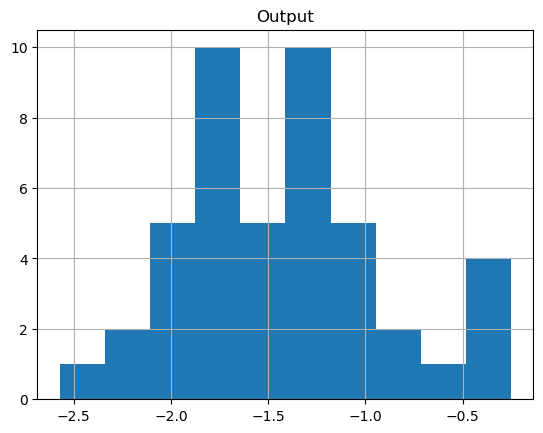

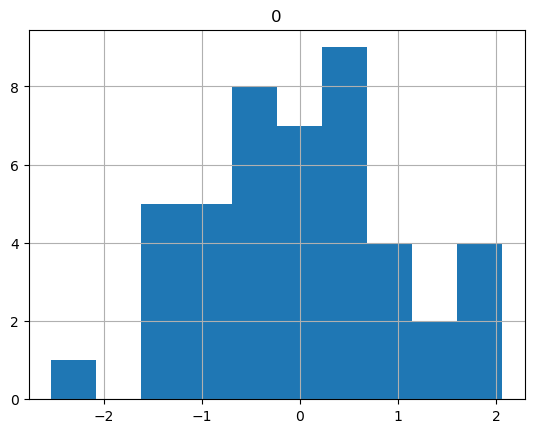

In [4]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

# Assuming f1_out is a NumPy array or a pandas Series
f1_out_transformed = PowerTransformer(method='yeo-johnson').fit_transform(f1_out.reshape(-1, 1))

# The transformed data is now stored in f1_out_transformed
f1_out, f1_out_transformed

pd_out.hist(), pd.DataFrame(f1_out_transformed).hist()

# ************************** Input Transformation************************** 
- #### First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

In [5]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize
from scipy.stats import skew 
from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)
np.std(f1_inp_normalized), np.std(f1_inp)
skew(f1_inp_normalized), skew(f1_inp)
# f1_inp_normalized

(array([-0.25290333,  0.14562051,  0.1250331 , -0.24655938,  0.20009725]),
 array([-0.25290333,  0.14562051,  0.1250331 , -0.24655938,  0.20009725]))

In [7]:
import numpy as np
from scipy.stats import skew
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm

# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

# Objective function
def evaluate(individual):
    a, b = individual
    X_warped = kumaraswamy_warp(f1_inp_normalized, a, b)
    variance = np.var(X_warped)
    skewness = np.mean(np.abs(skew(X_warped, axis=0)))
    return (variance + skewness,)

# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_a", random.uniform, 0.01, 2.0)
toolbox.register("attr_b", random.uniform, 0.01, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_a, toolbox.attr_b), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=50)

# Define number of generations
NGEN = 30
CX_PROB = 0.5
MUT_PROB = 0.2

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run Genetic Algorithm with progress bar
for gen in tqdm(range(NGEN), desc="Genetic Algorithm Generations"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual
best_ind = tools.selBest(population, k=1)[0]
best_a, best_b = best_ind
best_score = best_ind.fitness.values[0]

# Apply the best warp to the data
f1_inp_warped_best = kumaraswamy_warp(f1_inp_normalized, best_a, best_b)

# Calculate final variance and skewness
final_variance = np.var(f1_inp_warped_best)
final_skewness = np.mean(np.abs(skew(f1_inp_warped_best, axis=0)))

# Display the results
print("\n=== Best Kumaraswamy Parameters (GA) ===")
print(f"a = {best_a:.6f}")
print(f"b = {best_b:.6f}")
print(f"Combined Score (Variance + Skewness) = {best_score:.6f}")
print(f"Final Variance: {final_variance:.6f}")
print(f"Final Skewness: {final_skewness:.6f}")


Genetic Algorithm Generations:   0%|                                                                | 0/30 [00:00<?, ?it/s]C:\Users\alerd\AppData\Local\Temp\ipykernel_22276\3260814917.py:10: RuntimeWarning: invalid value encountered in power
  return 1 - (1 - X_clipped ** a) ** b
Genetic Algorithm Generations: 100%|███████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.59it/s]


=== Best Kumaraswamy Parameters (GA) ===
a = 0.485980
b = 0.520645
Combined Score (Variance + Skewness) = 0.146870
Final Variance: 0.071594
Final Skewness: 0.075276


(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
        [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object),
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
        [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object))

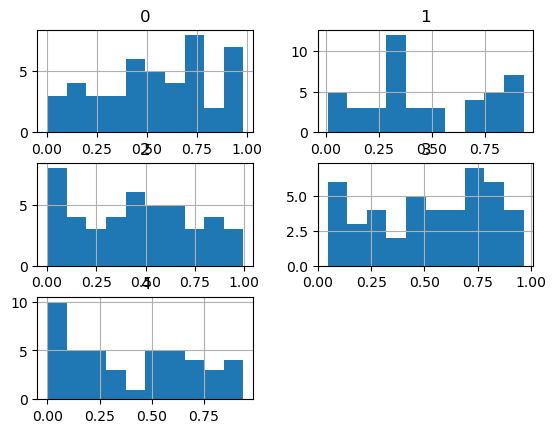

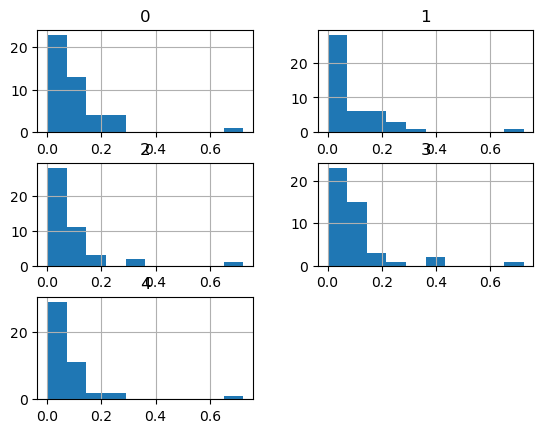

In [6]:
# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b


# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=1.080787, b=0.093696)
f1_inp, f1_inp_warped


np.var(f1_inp),skew(f1_inp), np.var(f1_inp_warped),skew(f1_inp_warped)

transformed=  pd.DataFrame(f1_inp_warped)

pd_inp.hist(), transformed.hist()

In [10]:
# SKEWNES IMPROVED/ POSITIVE RESULT

In [15]:
x_final =  f1_inp#f1_inp_warped
y_final  = f1_out_transformed


# ***************************** Gaussian Process****************************


# Testing Diffrent Kernels

- Inital parameters taken form the EDA 

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

# Initial parameters
# Initial parameters
amplitude_init = 0.46066385984326386
length_scale_init = np.array([0.30301465, 0.28361683, 0.31529164, 0.28025898, 0.29719864])
extended_min_bounds = np.array([-0.07186513,  0.032657, -0.07970539, -0.04599105, -0.08387927])
extended_max_bounds = np.array([1.05134011, 1.01361796, 1.07503405, 1.05325983, 0.98160996])


# Define kernels and hyperparameter ranges
kernels_list = [
    RBF(length_scale=1.0),
    Matern(length_scale=1.0, nu=1.5),
    Matern(length_scale=1.0, nu=2.5),
    RationalQuadratic(length_scale=1.0, alpha=1.0)
]

# Hyperparameter grids
amplitudes = np.linspace(0.8 * amplitude_init, 1.2 * amplitude_init, 10)  # Expanded to 10 points
length_scales = np.linspace(length_scale_init.mean() * 0.5, length_scale_init.mean() * 1.5, 10)  # Wider range
alphas = np.linspace(0.5, 2.5, 10)  # For RationalQuadratic

# Fixed noise level bounds
noise_level = 1e-5
noise_bounds = (1e-6, 1e-3)

# Placeholder for results
results = []

# Total iterations for progress bar
total_iterations = len(kernels_list) * len(amplitudes) * len(length_scales) * len(alphas)
progress_bar = tqdm(total=total_iterations, desc="Optimizing Kernels")

# Define a dummy data setup for illustration (replace with actual data)
X = f1_inp # 100 samples, 4 features
y = f1_out  # Target values

# Optimization loop
for kernel in kernels_list:
    for amp in amplitudes:
        for ls in length_scales:
            if isinstance(kernel, RationalQuadratic):
                for alpha in alphas:
                    # Create kernel with specified parameters
                    tuned_kernel = C(amp, (amp * 0.5, amp * 2.0)) * RationalQuadratic(length_scale=ls, alpha=alpha)
                    
                    # Initialize Gaussian Process with kernel
                    gp = GaussianProcessRegressor(kernel=tuned_kernel, alpha=noise_level, n_restarts_optimizer=5)
                    
                    # Fit and compute Log Marginal Likelihood (LML)
                    gp.fit(X, y)
                    lml = gp.log_marginal_likelihood()
                    
                    # Store results
                    results.append((kernel, amp, ls, alpha, lml))
            else:
                # Create kernel with specified parameters
                tuned_kernel = C(amp, (amp * 0.5, amp * 2.0)) * kernel.clone_with_theta([ls])
                
                # Initialize Gaussian Process with kernel
                gp = GaussianProcessRegressor(kernel=tuned_kernel, alpha=noise_level, n_restarts_optimizer=5)
                
                # Fit and compute Log Marginal Likelihood (LML)
                gp.fit(X, y)
                lml = gp.log_marginal_likelihood()
                
                # Store results
                results.append((kernel, amp, ls, None, lml))
            
            # Update progress bar
            progress_bar.update(1)

progress_bar.close()

# Sort results by LML (descending) and display the best result
results.sort(key=lambda x: x[-1], reverse=True)
best_result = results[0]

print("\nBest Kernel Configuration:")
print(f"Kernel: {best_result[0]}")
print(f"Amplitude: {best_result[1]:.3f}")
print(f"Length Scale: {best_result[2]:.3f}")
if best_result[3] is not None:
    print(f"Alpha: {best_result[3]:.3f}")
print(f"Log Marginal Likelihood: {best_result[4]:.3f}")


-  Results AFTER input/output transformation
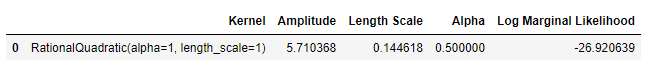

In [35]:
# Define column names for clarity
columns = ["Kernel", "Amplitude", "Length Scale", "Alpha", "Log Marginal Likelihood"]

# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns=columns)

# Convert numeric columns to appropriate data types if necessary
results_df["Amplitude"] = pd.to_numeric(results_df["Amplitude"], errors='coerce')
results_df["Length Scale"] = pd.to_numeric(results_df["Length Scale"], errors='coerce')
results_df["Alpha"] = pd.to_numeric(results_df["Alpha"], errors='coerce')
results_df["Log Marginal Likelihood"] = pd.to_numeric(results_df["Log Marginal Likelihood"], errors='coerce')

# Sort DataFrame by Log Marginal Likelihood in descending order to get the best result on top
results_df.sort_values(by="Log Marginal Likelihood", ascending=False, inplace=True)

# Display the top of the sorted DataFrame with explanations
print("\nBest Kernel Configurations:")
results_df.head()
results_df.iloc[-1]



Best Kernel Configurations:


Kernel                     Matern(length_scale=1, nu=2.5)
Amplitude                                        0.368531
Length Scale                                     0.410939
Alpha                                                 NaN
Log Marginal Likelihood                        -28.895268
Name: 1299, dtype: object


### Rational Quadritic Kernel is having the best score so far
- The good news is with this kernel we do not need to standarise the data as per the below instruction 
- Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000),

In [48]:
np.min(f1_inp)

0.004911495864404647

# - Final Kernel 

In [14]:
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

# Define the composite kernel with the Rational Quadratic kernel
kernel = (
    C(0.2**2, (1e-1, 1e3)) *  # Scaling factor squared
    RationalQuadratic(
        length_scale=0.1,  # Initial length scale
        alpha=1.0,  # Balances short- and long-term variations
        length_scale_bounds=(0.1, 2.0),
        alpha_bounds=(0.1, 10000000.0)
    ) +    WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-13, 0.001))  # Noise kernel
)

# Initialize Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Fit the GP model to your data
gp.fit(f1_inp, y_final)

# Output the optimized kernel and Log Marginal Likelihood
print("Optimized Kernel:", gp.kernel_)
print("Log Marginal Likelihood (LML):", gp.log_marginal_likelihood())


Optimized Kernel: 2.27**2 * RationalQuadratic(alpha=0.153, length_scale=1.24) + WhiteKernel(noise_level=0.001)
Log Marginal Likelihood (LML): -29.899448750256223


C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.001. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
# Best result when I removed tranformation THE ABOVE RESULT DOES NOT APPLY TRANFORMATION

In [19]:
import numpy as np
from scipy.stats import norm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, ExpSineSquared, WhiteKernel

class HEBOOptimizer:
    def __init__(self, bounds, initial_X=None, initial_y=None,
                 beta=2.5, xi=1.0, epsilon=0.1, random_state=None):
        """
        bounds: List of tuples [(min, max)] for each feature
        initial_X: Initial observed points (2D array)
        initial_y: Initial observed values (1D array)
        """
        self.bounds = np.array(bounds)
        self.dim = self.bounds.shape[0]  # Number of features
        self.beta = beta
        self.xi = xi
        self.epsilon = epsilon
        self.rng = np.random.RandomState(random_state)

        # Initialize data storage
        self.X = np.array(initial_X) if initial_X is not None else np.empty((0, self.dim))
        self.y = np.array(initial_y) if initial_y is not None else np.empty(0)

        # Adaptive length scales for all features
        length_scales = [1.0] * self.dim
        length_scale_bounds = [(3.43e-7, 10.0)] * self.dim
        length_scales[1] = 1000  # Ignore 2nd feature
        length_scale_bounds[1] = (1000, 1000)  # Fix its effect


        self.kernel = (
            C(0.2**2, (1e-1, 1e3)) *  # Scaling factor squared
            RationalQuadratic(
                length_scale=0.1,  # Initial length scale
                alpha=1.0,  # Balances short- and long-term variations
                length_scale_bounds=(0.1, 2.0),
                alpha_bounds=(0.1, 10000000.0)
            ) #+    WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-13, 0.001))  # Noise kernel
            )
    def _fit_gp(self):
        """Fit Gaussian Process with heteroscedastic noise"""
        gp = GaussianProcessRegressor(
            kernel=self.kernel,
            n_restarts_optimizer=10,
          #  alpha=0.0,  # Noise handled by WhiteKernel
            random_state=self.rng
        )
        if len(self.X) > 0:
            gp.fit(self.X, self.y)
        return gp

    def _stochastic_mean(self, mu, noise_var):
        """HEBO's noise-adjusted mean"""
        return mu + self.xi * noise_var

    def _mace_optimization(self, gp):
        """Core MACE multi-acquisition optimization"""
        class MACEProblem(Problem):
            def __init__(self, gp, bounds, best, beta, xi):
                super().__init__(n_var=len(bounds), n_obj=3,
                                xl=[b[0] for b in bounds], xu=[b[1] for b in bounds])
                self.gp = gp
                self.best = best
                self.beta = beta
                self.xi = xi

            def _evaluate(self, X, out, *args, **kwargs):
                mu, sigma = self.gp.predict(X, return_std=True)
                
                # Correct way to access noise level
                noise_var = self.gp.kernel_.get_params().get('k2__noise_level', 1e-9)
                
                mu_adj = mu + self.xi * noise_var  # HEBO's stochastic mean
                
                # Calculate acquisition functions
                sigma = np.maximum(sigma, 1e-9)  # Avoid divide by zero
                Z = (mu_adj - self.best) / sigma
                
                ei = (mu_adj - self.best) * norm.cdf(Z) + sigma * norm.pdf(Z)
                pi = norm.cdf(Z)
                ucb = mu_adj + self.beta * sigma
                
                # Minimize [-EI, -PI, UCB]
                out["F"] = np.column_stack([-ei, -pi, ucb])

        if len(self.y) == 0:
            return self._random_sample()
        
        problem = MACEProblem(gp, self.bounds, np.max(self.y), self.beta, self.xi)
        algorithm = NSGA2(pop_size=50, eliminate_duplicates=True)
        res = minimize(problem, algorithm, ("n_gen", 100), verbose=False)
        
        if res.X.size == 0:
            return self._random_sample()
        
        # Select best candidate from Pareto front (maximize EI)
        return res.X[np.argmax(-res.F[:, 0])]

    def _random_sample(self):
        """Generate random sample within bounds"""
        return np.array([self.rng.uniform(low, high) for (low, high) in self.bounds]).reshape(1, -1)

    def suggest_next_point(self):
        """Returns next candidate point for evaluation (maximization)"""
        # Epsilon-greedy exploration
        if self.rng.rand() < self.epsilon:
            return self._random_sample()
        
        # Fit GP with current data
        gp = self._fit_gp()
        
        # Skip optimization if no data
        if len(self.X) == 0:
            return self._random_sample()
        
        # Run MACE optimization
        candidate = self._mace_optimization(gp)
        
        # Ensure candidate is within bounds
        return np.clip(candidate, self.bounds[:, 0], self.bounds[:, 1])

    def update_data(self, X_new, y_new):
        """Update observed data with new point(s)"""
        self.X = np.vstack([self.X, np.atleast_2d(X_new)])
        self.y = np.concatenate([self.y, np.atleast_1d(y_new)])

        
        
        

## Change this depending if the input is normalised/tranformed or not
bounds = [(x_final[:, i].min(), x_final[:, i].max()) for i in range(x_final.shape[1])]


hebo = HEBOOptimizer(
    bounds=bounds,
    initial_X=x_final,
    initial_y=y_final,
    # Controls exploration in UCB: Higher β explores more, Lower β exploits more
    beta = 1.5,  # Expands search boundaries by considering high-uncertainty areas

    # Adjusts the stochastic mean: Higher ξ favors noisier, uncertain regions
    xi = 0.5, # Increases exploration in noisy areas, expanding search range

    # Exploration probability: Higher ε increases random sampling
    epsilon = 0.1 # Ad
)

# 3. Get next candidate point
next_point = hebo.suggest_next_point().flatten()
#next_point = hebo.suggest_next_point().reshape(-1)

# next z is predicited value at the inputs found from nextpoint, we use gausian
# process that we had trained above 
next_z = hebo._fit_gp().predict(next_point.reshape(1, -1))[0]
print(f"Next point to evaluate: {next_point}")
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.2, random_state=42)

gp = hebo._fit_gp()
y_pred, y_std = gp.predict(X_test, return_std=True)

# Compute Mean Squared Error
mse = np.mean((y_pred - y_test) ** 2)


print(next_z)
# # Print information about the points
# print(f"Maximum Value: {max_z:.8e} at (x1={max_x:.4f}, x2={max_y:.6f}) at output, {np.max(y_final)}")
# print(f"Minimum Value: {min_z:.8e} at (x1={min_x:.4f}, x2={min_y:.6f})")
# print(f"Last Added Point: {last_z:.8e} at (x1={last_x:.6f}, x2={last_y:.6f})")
# print(f"Mean Squared Error (MSE): {mse}")
# print("------------------------------------------------------------------------------------------------------------")
print(f"Next Best Point (MACE): {next_z:.8e} at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f}, x3={next_point[2]:.6f} , x4={next_point[3]:.6f}, x3={next_point[2]:.6f} , x4={next_point[4]:.6f} )")

Next point to evaluate: [0.38805929 0.4180592  0.64199871 0.70712917 0.10062606]
2.0073610836475906
Next Best Point (MACE): 2.00736108e+00 at (x1=0.388059, x2=0.418059, x3=0.641999 , x4=0.707129, x3=0.641999 , x4=0.100626 )


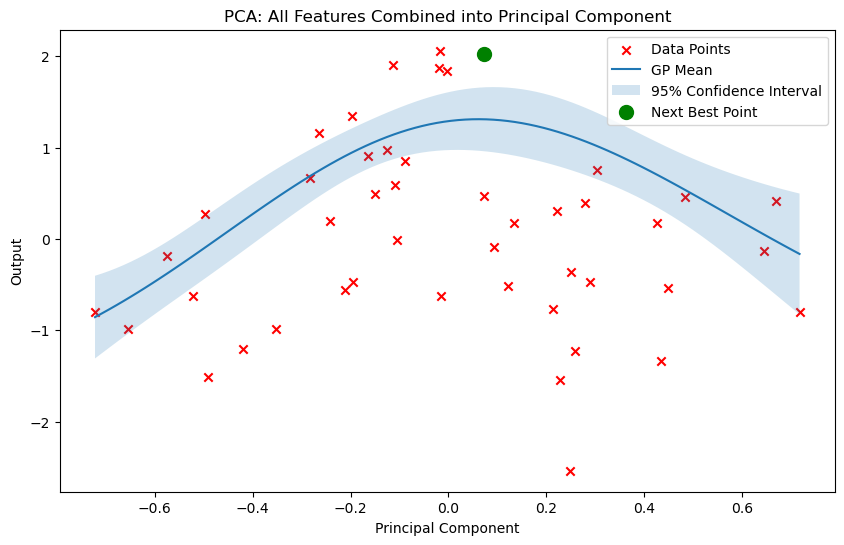

Next best point (4D): [0.40337971 0.42050422 0.63123397 0.71812879 0.11913881]
Predicted value at next best point: 2.027212


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 1D
pca = PCA(n_components=1)
t_data = pca.fit_transform(x_final).ravel()
t_next = pca.transform(next_point.reshape(1, -1)).item()

# Create a grid along the PCA component
t_values = np.linspace(t_data.min(), t_data.max(), 100)
X_plot = pca.inverse_transform(t_values.reshape(-1, 1))

gp = hebo._fit_gp()

# Get next best point from HEBO
next_point = hebo.suggest_next_point().flatten()
# GP predictions along the grid
mean_pred, std_pred = gp.predict(X_plot, return_std=True)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(t_data, y_final, color='red', marker='x', label='Data Points')
plt.plot(t_values, mean_pred, label='GP Mean')
plt.fill_between(t_values, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred, alpha=0.2, label='95% Confidence Interval')
plt.scatter(t_next, gp.predict(next_point.reshape(1, -1))[0], color='green', s=100, marker='o', label='Next Best Point')
plt.title('PCA: All Features Combined into Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Output')
plt.legend()
plt.show()

print("Next best point (4D):", next_point)
print(f"Predicted value at next best point: {gp.predict(next_point.reshape(1, -1))[0]:.6f}")


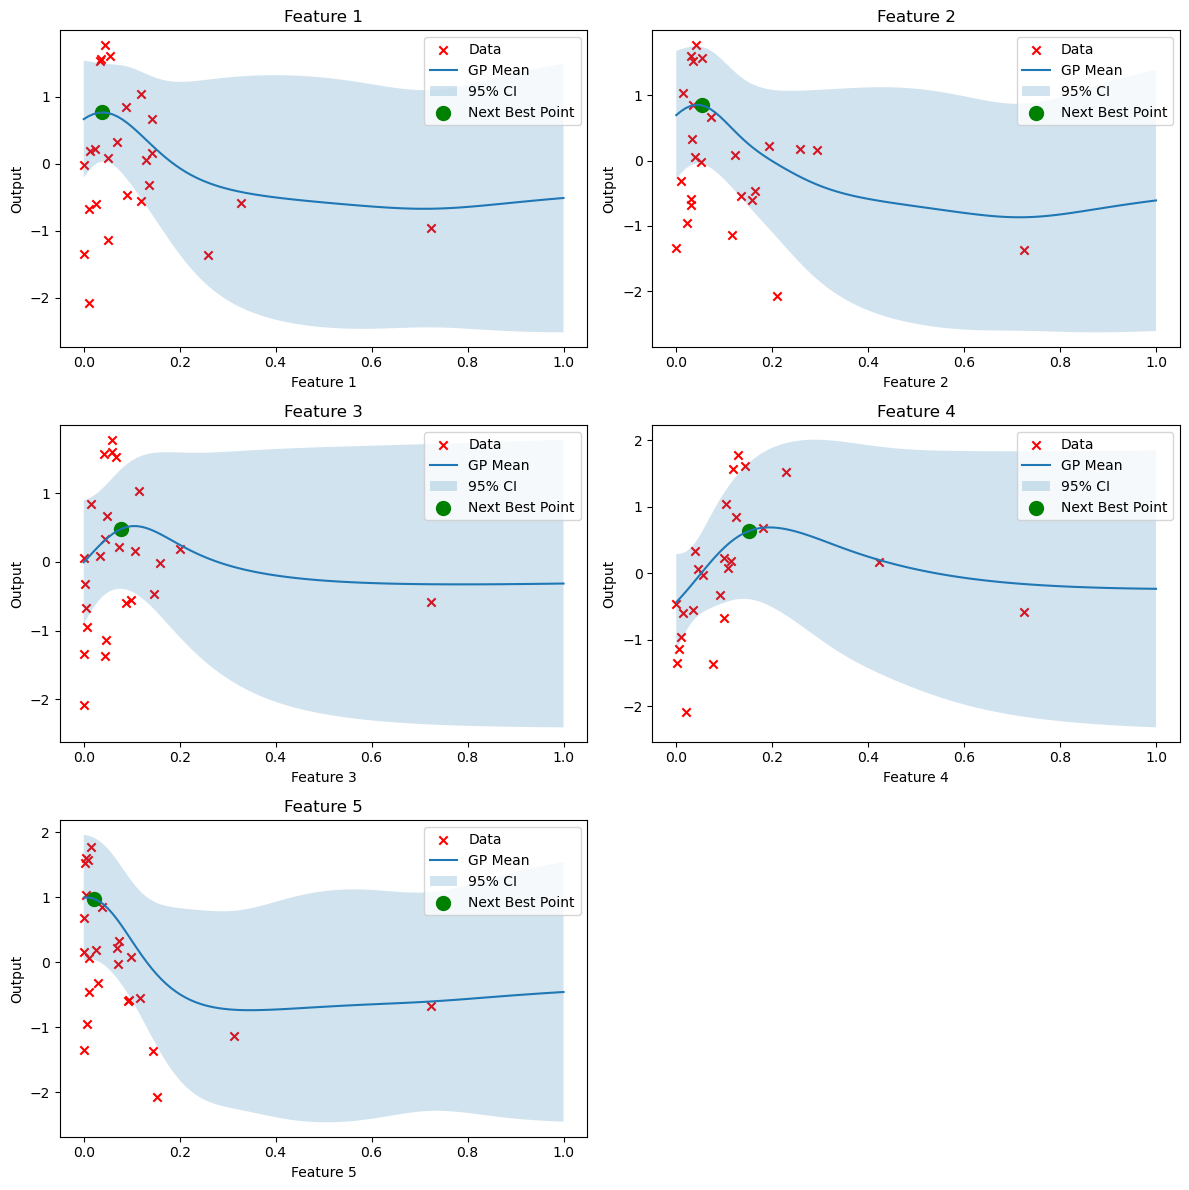

Next best point (nD): [0.03736742 0.05295265 0.0775562  0.15067461 0.02225743]
Predicted mean at next best point: 1.9037
Predicted std at next best point: 0.2079


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Number of features
n_features = x_final.shape[1]

# Calculate feature means and set up grid
means_other_features = np.mean(x_final, axis=0)
grid = np.linspace(0, 1, 100)

# Predict at the next best point
next_mean, next_std = gp.predict(next_point.reshape(1, -1), return_std=True)

# Determine the subplot arrangement (rows x cols)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # Flatten to easily iterate

for i in range(n_features):
    ax = axes[i]

    # Prepare grid points for this feature
    X_plot = np.tile(means_other_features, (100, 1))
    X_plot[:, i] = grid
    mean_pred, std_pred = gp.predict(X_plot, return_std=True)

    # Plot data, GP mean, and confidence interval
    ax.scatter(x_final[:, i], y_final, color='r', marker='x', label='Data')
    ax.plot(grid, mean_pred, label='GP Mean')
    ax.fill_between(grid, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred,
                    alpha=0.2, label='95% CI')
    
    # Highlight next best point
    X_next = means_other_features.copy()
    X_next[i] = next_point[i]
    y_next_dim = gp.predict(X_next.reshape(1, -1))[0]
    ax.scatter(next_point[i], y_next_dim, color='green', s=100, marker='o', label='Next Best Point')

    ax.set_title(f'Feature {i+1}')
    ax.set_xlabel(f'Feature {i+1}')
    ax.set_ylabel('Output')
    ax.legend()

# Hide any unused subplots if n_features isn't a multiple of 2
for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("Next best point (nD):", next_point)
print(f"Predicted mean at next best point: {next_mean[0]:.4f}")
print(f"Predicted std at next best point: {next_std[0]:.4f}")


In [15]:
def format_val(v):
    # Ensure v is a numpy array
    v = np.array(v) if not isinstance(v, np.ndarray) else v
    
    # Format each value as a string with six decimal places
    formatted = '-'.join(f"{val:.6f}" for val in v.flatten())
    
    # Print the requested format
    print(f"The requested format for submitting the queries is {formatted}")
    return formatted

next_point_original = format_val(next_point)
next_point_original

The requested format for submitting the queries is 0.037367-0.052953-0.077556-0.150675-0.022257


'0.037367-0.052953-0.077556-0.150675-0.022257'

In [34]:
# Changed to the below for mor explotation 

In [53]:
#